# Get TNG Data

In this notebook, we will download a set of TNG data. My personal interest here is to keep as many data dimensions as possible.

In [9]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from io import BytesIO
import json
import h5py
import os
import requests
from scipy.stats import binned_statistic_2d

api_key = "your-api-key"

def get(path, params=None):
    # make HTTP GET request to path
    headers = {"api-key":api_key}
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string

    return r

Some helper functions

In [10]:
def gas_temperature(gas):
    # calculate the temperature because apparently, physicians love to do the math by themselves...
    u = np.array(gas["InternalEnergy"])
    x_e = np.array(gas["ElectronAbundance"])
    x_h = 0.76
    gamma = 5/3
    k_b = 1.380649 * 10**(-16)
    mu = (4/(1 + 3*x_h + 4*x_h*x_e)) * np.array(gas["Masses"])
    unit_length = 3.086*(10**21) # 1 kpc
    unit_time = 3.1536*(10**16) # 1 Gyr
    temp = (gamma -1) * u/k_b * (unit_length**2 / unit_time**2) * mu
    return temp

def circle_mask(coords, values, radius=100.):
    x = coords[0]
    y = coords[1]
    z = coords[2]
    new_x, new_y, new_z, new_values = [], [], [], []
    for i in range(len(values)):
        distance = np.sqrt((x[i] ** 2) + (y[i] ** 2) + (z[i] ** 2))
        if distance <= radius:
            new_x.append(x[i])
            new_y.append(y[i])
            new_z.append(z[i])
            new_values.append(values[i])
    return np.array(new_x), np.array(new_y), np.array(new_z), np.array(new_values)

def binned_stats(data, subhalo, value, min_max):
    dist_units_kpc = 1.476232654266312
    x = np.array(data['Coordinates'][:, 0] - subhalo['pos_x']) * dist_units_kpc
    y = np.array(data['Coordinates'][:, 1] - subhalo['pos_y']) * dist_units_kpc
    z = np.array(data['Coordinates'][:, 2] - subhalo['pos_z']) * dist_units_kpc
    img , _, _, _ = binned_statistic_2d(x, y, value, 'sum', bins=[128, 128], range=[min_max, min_max] )
    
    return img

Some functions to visualize some dimensions of the data. They are not necessary if you just want to download the hdf5 files, but they may show a good example on how to work with hdf5.

In [11]:
from matplotlib import colors as c
import numpy as np

dist_units_kpc = 1.476232654266312

def make_stellar_mock(subhalo):
     if 'stellar_mocks' in subhalo['supplementary_data']: 
        plt.figure(figsize=(10,10))
        # download PNG image, the version which includes all stars in the FoF halo (try replacing 'fof' with 'gz')
        png_url = subhalo['supplementary_data']['stellar_mocks']['image_fof']
        response = get(png_url)
         
        # make plot a bit nicer
        plt.text(0,-20,"ID="+str(id),color='blue')
        plt.gca().axes.get_xaxis().set_ticks([])
        plt.gca().axes.get_yaxis().set_ticks([])
         
        # plot the PNG binary data directly, without actually saving a .png file
        file_object = BytesIO(response.content)
        plt.imshow(mpimg.imread(file_object))
        
        
def make_ply(gas, subhalo):
    
    
    g_x = (gas['Coordinates'][:, 0] - subhalo['pos_x']) *dist_units_kpc
    g_y = (gas['Coordinates'][:, 1] - subhalo['pos_y']) *dist_units_kpc
    g_z = (gas['Coordinates'][:, 2] - subhalo['pos_z']) *dist_units_kpc
    
    g_pot = gas['Potential']
    x, y, z, values = circle_mask((g_x, g_y, g_z), g_pot)

    # Normalize
    values /= values.mean()
    

    # Make a color map that sets transparancy according to density
    cmap = plt.cm.magma
    my_cmap = cmap(np.arange(cmap.N))
    my_cmap[:,-1] = np.logspace(0., 1., cmap.N, endpoint=True)/10.
    my_cmap = c.ListedColormap(my_cmap)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(elev=90, azim=90, roll=0)

    #ax.scatter(s_x, s_y, s_z, s=s_masses*1.)
    gas_scatter = ax.scatter(x, y, z, c=values, s=1., cmap=my_cmap)

    ax.set_xlim3d(-100, 100)
    ax.set_ylim3d(-100, 100)



    ax.set_xlabel('X [kpc]')
    ax.set_ylabel('Y [kpc]')
    ax.set_zlabel('Z [kpc]')

    plt.show()
 

   
def gas_density(gas, subhalo):
    dist_units_kpc = 1.476232654266312
    
    temperature = gas_temperature(gas)
    sf_rate = np.array(gas["StarFormationRate"])
    cooling_rate = np.array(gas["GFM_CoolingRate"])
    
    mask = np.where(temperature > 3.0e5) and np.where(sf_rate == 0.0) and np.where(cooling_rate < 0.0)
    hot_gas_density = np.array(gas["Density"])[mask]
    
    g_x = np.array(gas['Coordinates'][:, 0] - subhalo['pos_x']) * dist_units_kpc
    g_y = np.array(gas['Coordinates'][:, 1] - subhalo['pos_y']) * dist_units_kpc
    g_z = np.array(gas['Coordinates'][:, 2] - subhalo['pos_z']) * dist_units_kpc
    
    min_max = [-20,20]
    density, _, _, _ = binned_statistic_2d(g_x, g_y, np.array(gas["Density"]),    
                                         'sum', bins=[128,128], range=[min_max, min_max] )
    hot_density, _, _, _ = binned_statistic_2d(g_x[mask], g_y[mask], hot_gas_density,    
                                         'sum', bins=[128,128], range=[min_max, min_max] )
    
    extent = [min_max[0], min_max[1], min_max[0], min_max[1]]
    
    plt.figure()
    plt.imshow(density, extent=extent, aspect=1)
    plt.figure()
    plt.imshow(hot_density, extent=extent, aspect=1)
    

def star_point_cloud(stars, subhalo):
    x = (stars['Coordinates'][:, 0] - subhalo['pos_x']) *dist_units_kpc
    y = (stars['Coordinates'][:, 1] - subhalo['pos_y']) *dist_units_kpc
    z = (stars['Coordinates'][:, 2] - subhalo['pos_z']) *dist_units_kpc
    
    density = np.array(stars['SubfindDensity'])
    print("Density", density)
    mass = np.array(stars['Masses'])
    print("Mass", mass*14762326542.663124)
    volume = mass / density
    print("Volume", volume)
    radius = ((3/4)*(volume/np.pi))**(1/3) *dist_units_kpc
    print("Radius", radius)
    
    star_meshes = []
    

def show_gas_temperature(gas, subhalo):
    temperature = gas_temperature(gas)
    min_max = [-20,20]
    px_size = (min_max[1] - min_max[0]) / 128.
    gas_t = binned_stats(gas, subhalo, np.array(temperature), min_max)
    extent = [min_max[0], min_max[1], min_max[0], min_max[1]]
    
    plt.figure()
    plt.imshow(np.log10(gas_t), extent=extent)
    plt.xlabel("Distance from Galactic center [kpc]")
    plt.ylabel("Distance from Galactic center [kpc]")
    plt.colorbar(label="Gas Temperature [log(K)]")
    
    
def show_dark_matter(dm, subhalo):
    to_msun = 14762326542.663124

    dm_density = dm['SubfindDensity']
    min_max = [-20,20]
    dmd = binned_stats(dm, subhalo, np.log(np.array(dm_density)), min_max)
    extent = [min_max[0], min_max[1], min_max[0], min_max[1]]
    
    plt.figure()
    plt.imshow(dmd, extent=extent)
    plt.xlabel("Distance from Galactic center [kpc]")
    plt.ylabel("Distance from Galactic center [kpc]")
    plt.colorbar(label="Dark Matter Density [log(Msun / kpc)]")


## Query from TNG

We take Galaxies from Snapshot 99 in TNG100-1.
I just pasted 1000 Subhalo IDs hardcoded into this notebook.

In [15]:
#@Todo: If you like, you can change dataset and snapshot number
base_path = "http://www.tng-project.org/api/TNG100-1/"

#@Todo: Enter a map of subhalo IDs that are of interest, indexed by snapshot numbers
subhalo_ids = {99: [454795,454898,454963,455058,455109,455198]}


<KeysViewHDF5 ['CenterOfMass', 'Coordinates', 'Density', 'ElectronAbundance', 'EnergyDissipation', 'GFM_AGNRadiation', 'GFM_CoolingRate', 'GFM_Metallicity', 'GFM_Metals', 'GFM_MetalsTagged', 'GFM_WindDMVelDisp', 'GFM_WindHostHaloMass', 'InternalEnergy', 'Machnumber', 'MagneticField', 'MagneticFieldDivergence', 'Masses', 'NeutralHydrogenAbundance', 'ParticleIDs', 'Potential', 'StarFormationRate', 'SubfindDMDensity', 'SubfindDensity', 'SubfindHsml', 'SubfindVelDisp', 'Velocities']>


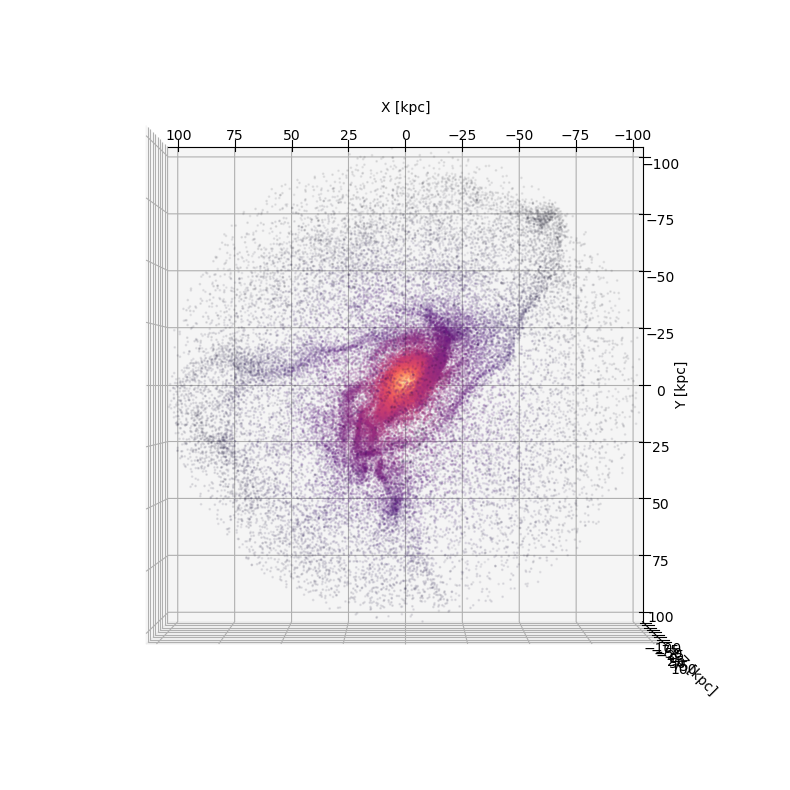

In [18]:

def get_subhalo(snap_num, sid, demo=False):
    url = os.path.join(base_path,"snapshots",str(snap_num),"subhalos",str(sid))
    subhalo = get(url)
    #try:
    fits = get(url + "/skirt/broadband_sdss.fits")
    #except:
        #print(f"No FITS file was found - Skipping halo {sid}")
        #return
    
    hdf = get(url + "/cutout.hdf5")
    info = get(url + "/info.json")         
    
    # Turn demo off, ifyou simply want to download the files
    if demo:
        with h5py.File(hdf) as f:
            gas = f['PartType0']
            print(gas.keys())
            make_ply(gas, subhalo)
    return info.keys()
            
            
snap_num = list(subhalo_ids.keys())[0]
sids = subhalo_ids[snap_num]
infokeys = get_subhalo(snap_num, sids[0], demo=True)

### Download all cutouts
Will save cutout hdf5 files to the direction of this notebook.

In [19]:
from tqdm import tqdm

for snap_num in subhalo_ids.keys():
    for sid in tqdm(subhalo_ids[snap_num]):
        get_subhalo(snap_num, sid)

100%|█████████████████████████████████████████████| 6/6 [00:35<00:00,  5.98s/it]


### Create catalog
Save physical properties of the subhalos as a csv file.

In [20]:
import csv
from tqdm import tqdm

with open('TNG100-1.csv', 'w') as f:
    writer = csv.DictWriter(f, infokeys)
    writer.writeheader()
    for snap_num in subhalo_ids.keys():
        for sid in tqdm(subhalo_ids[snap_num]):
            url = os.path.join(base_path,"snapshots",str(snap_num),"subhalos",str(sid))
            info = get(url + "/info.json")
            writer.writerow(info)

100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.53it/s]
